# Investigating adjusted p-values from eQTL analysis

__Author:__ Bryan Quach  
__Date:__ April 11, 2017

### Estimated Analysis Time: <1 days

## Objective

There are multiple objectives of this analysis. The main goal is to apply multiple testing correction to the initial results of the eQTL analyses (unadjusted p-values). Following the multiple testing correction, we will address the following questions:

* What is the q-value distribution of our results?
* How many gene-marker pairs produced a significant association?
* How many statistically significant eQTL-containing genes (eGenes) are observed?
* Which gene and marker comparisons produced the most significant hits?
* Which genes tested are eGenes?

## Software required

* [dplyr (R package)](https://cran.r-project.org/web/packages/dplyr/index.html)
* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)

## The Data

The data that we work with are results output from running a modified version of Daniel Oreper's eQTL analysis software. This software produces an R data file containing the environment in which the analysis was run, which includes a matrix of p-values with rows and columns corresponding to genes and markers respectively. In this analysis, we will look at results for the eQTL analyses in lung, liver, and kidney control samples.

## Global multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values will be used for assessing significance of all gene-marker pairs at a specified threshold. To aid in data analysis, we will convert our matrices of p-values into a data frame with `NA` values removed.

In [2]:
library(dplyr)
library(qvalue)

# Function for retrieving non-NA values from matrix
#
# Args:
#   haystack - matrix to search through
#
# Returns a dataframe of the p-values with gene and marker names listed
reshape.results <- function(haystack){
    hits <- which(!is.na(haystack), arr.ind=T)
    rnames <- rownames(haystack)[hits[,1]]
    cnames <- colnames(haystack)[hits[,2]]    
    pvals <- sapply(1:nrow(hits), function(i){haystack[hits[i,1], hits[i,2]]})
    results <- data.frame(gene=rnames, marker=cnames, pval=as.numeric(pvals))
    results <- results[order(results$gene),]
    return(results)
}

#Get p-value matrices for each tissue
tmp.env <- new.env()
load("data/control_lung.Rdata", envir=tmp.env)
matrix.lung <- get("out.mat", tmp.env)
load("data/control_liver.Rdata", envir=tmp.env)
matrix.liver <- get("out.mat", tmp.env)
load("data/control_kidney.Rdata", envir=tmp.env)
matrix.kidney <- get("out.mat", tmp.env)
rm(tmp.env)

#Reshape
pvals.lung <- reshape.results(matrix.lung)
pvals.liver <- reshape.results(matrix.liver)
pvals.kidney <- reshape.results(matrix.kidney)

#Apply FDR correction
qvals.lung <- qvalue(pvals.lung$pval, fdr.level=0.1) 
qvals.liver <- qvalue(pvals.liver$pval, fdr.level=0.1)
qvals.kidney <- qvalue(pvals.kidney$pval, fdr.level=0.1)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Identifying significant eGenes

For downstream analyses that focus only on the gene-level results, we will assign a representative p-value for each gene. A common approach to do this is to use the smallest p-value for a gene across tests as a test statistic. A permutation test is then applied where the gene expression values are permuted, and a p-value is derived from this permutation test procedure. Because this is computationally too expensive given our current resources, we will instead apply [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to the p-values from each marker test with a gene. In this approach we tabulate the number of tests performed for each gene then multiply each p-value by that number. We will use the smallest Bonferroni corrected p-value as the representative p-value for a gene. We will then account for multiple comparisons across genes by appyling FDR correction.

In [3]:
#Apply Bonferroni correction
matrix.adj.lung <- matrix.lung * apply(matrix.lung,1,function(x){length(which(!is.na(x)))})
matrix.adj.liver <- matrix.liver * apply(matrix.liver,1,function(x){length(which(!is.na(x)))})
matrix.adj.kidney <- matrix.kidney * apply(matrix.kidney,1,function(x){length(which(!is.na(x)))})

#Apply value ceiling of 1 to p-values
matrix.adj.lung <- apply(matrix.adj.lung, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.liver <- apply(matrix.adj.liver, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.kidney <- apply(matrix.adj.kidney, 2, function(x){ifelse(x>1,1,x)})

#Assign representative p-value to each gene
gene.pval.lung <- apply(matrix.adj.lung, 1, min, na.rm=T)
if(length(which(gene.pval.lung==Inf))>0){ gene.pval.lung <- gene.pval.lung[-1*which(gene.pval.lung==Inf)] }
gene.pval.liver <- apply(matrix.adj.liver, 1, min, na.rm=T)
if(length(which(gene.pval.liver==Inf))>0){ gene.pval.liver <- gene.pval.liver[-1*which(gene.pval.liver==Inf)] }
gene.pval.kidney <- apply(matrix.adj.kidney, 1, min, na.rm=T)
if(length(which(gene.pval.kidney==Inf))>0){ gene.pval.kidney <- gene.pval.kidney[-1*which(gene.pval.kidney==Inf)] }

#Apply FDR correction
gene.qval.lung <- qvalue(p=gene.pval.lung, fdr.level=0.1)
gene.qval.liver <- qvalue(p=gene.pval.liver, fdr.level=0.1)
gene.qval.kidney <- qvalue(p=gene.pval.kidney, fdr.level=0.1)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”

## Plotting statistics

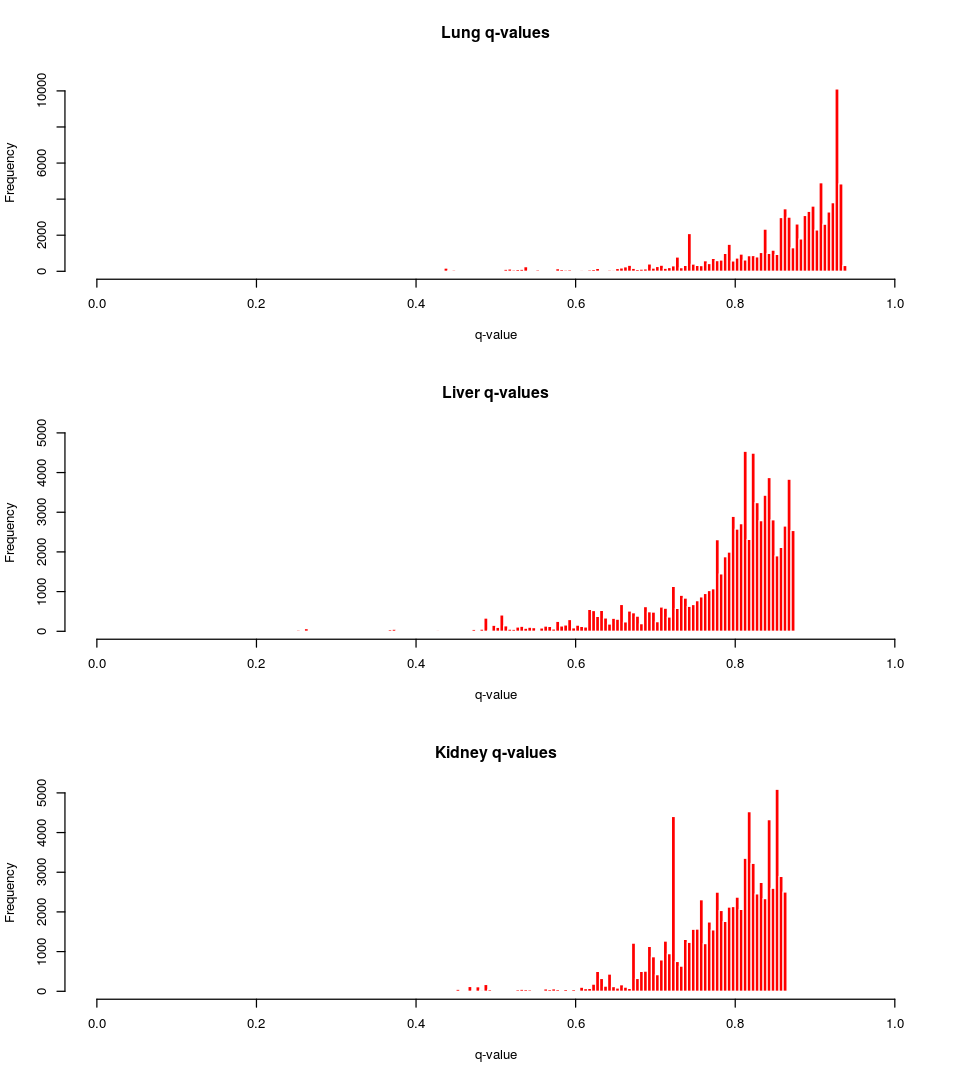

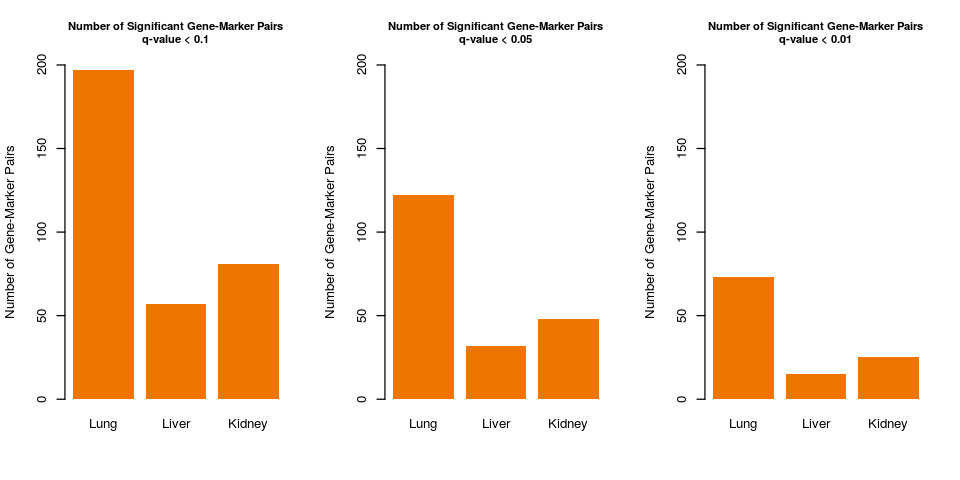

In [15]:
library(repr)

#P-value distributions
options(repr.plot.width=8, repr.plot.height=9)
par(mfrow=c(3,1))
hist(as.numeric(qvals.lung$qvalues), breaks=200, freq=T, ylim=c(0,11000), xlim=c(0,1),
     col="red", border="white",
     main="Lung q-values",
     ylab="Frequency",
     xlab="q-value")
hist(as.numeric(qvals.liver$qvalues), breaks=200, freq=T, ylim=c(0,5000), xlim=c(0,1),
     col="red", border="white",
     main="Liver q-values",
     ylab="Frequency", 
     xlab="q-value")
hist(as.numeric(qvals.kidney$qvalues), breaks=200, freq=T, ylim=c(0,5000), xlim=c(0,1),
     col="red", border="white",
     main="Kidney q-values",
     ylab="Frequency", 
     xlab="q-value")


#Calculate significant eGenes and gene marker pairs
for(cutoff in c(0.1,0.05,0.01)){
    num.egenes.lung <- length(which(gene.qval.lung$qvalues<cutoff))
    num.egenes.liver <- length(which(gene.qval.liver$qvalues<cutoff))
    num.egenes.kidney <- length(which(gene.qval.kidney$qvalues<cutoff))
    assign(x=paste0("num.egenes.",cutoff),value=c(num.egenes.lung, num.egenes.liver, num.egenes.kidney))

    num.sig.lung <- length(which(qvals.lung$qvalues<cutoff))
    num.sig.liver <- length(which(qvals.liver$qvalues<cutoff))
    num.sig.kidney <- length(which(qvals.kidney$qvalues<cutoff))
    assign(x=paste0("num.sig.",cutoff),value=c(num.sig.lung, num.sig.liver, num.sig.kidney))
}

#Significant eGenes
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
barplot(height=num.egenes.0.1, beside=T, ylab="Number of Genes", ylim=c(0,50),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.1",
        cex.main=0.85)
barplot(height=num.egenes.0.05, beside=T, ylab="Number of Genes", ylim=c(0,50),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.05",
        cex.main=0.85)
barplot(height=num.egenes.0.01, beside=T, ylab="Number of Genes", ylim=c(0,50),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.01",
        cex.main=0.85)


#Significant gene marker paris
par(mfrow=c(1,3))
barplot(height=num.sig.0.1, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,200),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.1",
        cex.main=0.85)
barplot(height=num.sig.0.05, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,200),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.05",
        cex.main=0.85)
barplot(height=num.sig.0.01, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,200),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.01",
        cex.main=0.85)

## Retrieving most significant associations

For each tissue, we retrieve the 100 gene-marker pairs that produced the most significant q-values and list them below. Notably, not all the records listed have q-values that would pass typical thresholds.

In [46]:
#Load marker coordinates and gene expression data
tmp.env <- new.env()
load("data/control_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.lung <- tmp.data$exp.mat
marker.map <- tmp.data$marker.map
load("data/control_liver.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.liver <- tmp.data$exp.mat
load("data/control_kidney.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.kidney <- tmp.data$exp.mat
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.list <- cbind(pvals.lung, qval=qvals.lung$qvalues)
lung.list <- lung.list[order(lung.list$qval),]
liver.list <- cbind(pvals.liver, qval=qvals.liver$qvalues)
liver.list <- liver.list[order(liver.list$qval),]
kidney.list <- cbind(pvals.kidney, qval=qvals.kidney$qvalues)
kidney.list <- kidney.list[order(kidney.list$qval),]
top.lung.list <- lung.list[1:100,]
top.liver.list <- liver.list[1:100,]
top.kidney.list <- kidney.list[1:100,]

#Get genomic coordinates for top markers
get.location <- function(marker, marker.map){
    boundary.markers <- unlist(strsplit(x=marker, split=".", fixed=T))
    m.index1 <- which(marker.map$marker==boundary.markers[1])
    m.index2 <- which(marker.map$marker==boundary.markers[2])
    if(length(m.index1)!=1 | length(m.index2)!=1){
        error_msg <- paste0("Error: Marker not found in marker map: ", marker)
        stop(error_msg)
    }
    #Get marker region
    m1 <- marker.map[m.index1,]
    m2 <- marker.map[m.index2,]
    if(m1$chromosome!=m2$chromosome){stop("Error: Markers merged across chromosomes!")}
    m.region <- c(m1$chromosome, m1$position, m2$position)
    return(m.region)
}
top.lung.list <- cbind(top.lung.list, t(sapply(as.character(top.lung.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.liver.list <- cbind(top.liver.list, t(sapply(as.character(top.liver.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.kidney.list <- cbind(top.kidney.list, t(sapply(as.character(top.kidney.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
colnames(top.lung.list)[3:5] <- c("chr", "start", "end")
colnames(top.liver.list)[3:5] <- c("chr", "start", "end")
colnames(top.kidney.list)[3:5] <- c("chr", "start", "end")

#Get gene expression statistics
gene.calc <- function(gene, expression){
    abundance <- expression[,colnames(expression)==gene]
    return(c(mean(abundance), sd(abundance), range(abundance)))
}
gene.stats.lung <- t(sapply(top.lung.list$gene, gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(top.liver.list$gene, gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(top.kidney.list$gene, gene.calc, expression=rna.levels.kidney))
top.lung.list <- cbind(top.lung.list, gene.stats.lung)
top.liver.list <- cbind(top.liver.list, gene.stats.liver)
top.kidney.list <- cbind(top.kidney.list, gene.stats.kidney)
colnames(top.lung.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.liver.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.kidney.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")

#Display tables
cat("Lung\n")
top.lung.list
cat("Liver\n")
top.liver.list
cat("Kidney\n")
top.kidney.list

#Write tables to file
write.table(x=top.lung.list, file="results/lung_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.liver.list, file="results/liver_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.kidney.list, file="results/kidney_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")


Lung


gene     marker                         chr   start     end      
647   AI597479 JAX00248662.UNC541737          chr1  42383626  42688637 
639   AI597479 UNC533184.UNC536663            chr1  42075848  42338285 
31333 Sdhaf1   UNC12572462.UNC12573732        chr7  31229864  31312408 
717   Dnah7b   UNC578793.UNC597735            chr1  45313373  46963812 
20895 Gm3414   UNC9076911.UNC9083687          chr5  45151477  45681428 
31335 Syne4    UNC12572462.UNC12573732        chr7  31229864  31312408 
20056 Srpk2    UNC8769425.UNC8791233          chr5  21016194  22478235 
658   Tpp2     JAX00248770.UNC547234          chr1  42708016  43093838 
666   Tpp2     JAX00248843.JAX00248843        chr1  43103831  43103831 
678   Tpp2     UNC547351.UNC549896            chr1  43107520  43272443 
692   Tpp2     UNC550060.UNC557806            chr1  43289978  43742556 
711   Tpp2     JAX00249009.UNC577593          chr1  43743194  45188002 
855   Bzw1     UNC718116.UNC734946            chr1  56309822  57836503 
20815 Zbtb49   UNC8990872.UNC8994596          chr5  38811294  39057615 
700   Dnah7b   JAX00249009.UNC577593          chr1  43743194  45188002 
31337 Tmem147  UNC12572462.UNC12573732        chr7  31229864  31312408 
718   Dnah7c   UNC578793.UNC597735            chr1  45313373  46963812 
858   Fam126b  UNC718116.UNC734946            chr1  56309822  57836503 
20051 Ptpn12   UNC8769425.UNC8791233          chr5  21016194  22478235 
20026 Ptpn12   UNC8760878.UNC8769129          chr5  20434895  21005163 
19994 Ptpn12   UNC8744830.UNC8757015          chr5  19273068  20112984 
20010 Ptpn12   UNC8757558.UNC8760307          chr5  20151188  20378767 
496   Mitd1    JAX00002582.UNC474632          chr1  37614784  38262134 
31161 Paf1     UNC12549403.UNC12567534        chr7  29589840  30930206 
519   Mitd1    UNC474803.JAX00247605          chr1  38274756  38617193 
31066 Paf1     UNC12543724.UNC12548710        chr7  29110157  29536489 
30929 Paf1     UNC12542093.UNC12543129        chr7  28910807  29040349 
30997 Paf1     UNC12543518.UNC12543518        chr7  29082051  29082051 
808   Sf3b1    UNC671186.UNC692837            chr1  52498726  54356006 
840   Sf3b1    UNC699866.JAX00003956          chr1  54864353  55969159 
⋮     ⋮        ⋮                              ⋮     ⋮         ⋮        
30509 Timm50   UNC12521588.UNC12531236        chr7  27079399  28104183 
72452 Mpc1     UNC27534981.UNC27536218        chr17 8537587   8650044  
30950 Timm50   UNC12542093.UNC12543129        chr7  28910807  29040349 
21052 Sepsecs  UNC9182307.UNC9194098          chr5  52686847  53449168 
13731 Col25a1  UNC6250492.UNC6250492          chr3  130699555 130699555
31018 Timm50   UNC12543518.UNC12543518        chr7  29082051  29082051 
31187 Timm50   UNC12549403.UNC12567534        chr7  29589840  30930206 
31088 Timm50   UNC12543724.UNC12548710        chr7  29110157  29536489 
13741 Col25a1  UNC6250875.UNC6250875          chr3  130734570 130734570
13751 Col25a1  UNC6251370.UNC6251370          chr3  130778265 130778265
13762 Col25a1  UNC6251528.UNC6260458          chr3  130800235 131430133
1154  Map2     UNC810365.UNC010113351         chr1  64617650  66243536 
2696  Rnf2     UNC1953417.UNC1966373          chr1  153911422 154712538
21069 Sepsecs  UNC9194356.JAX00582642         chr5  53474988  53501844 
71062 Olfr172  UNC26908820.UNC26909630        chr16 58562352  58660429 
60999 Nhlrc1   UNC22553195.UNC22578692        chr13 47325689  50588947 
682   Bivm     UNC550060.UNC557806            chr1  43289978  43742556 
697   Bivm     JAX00249009.UNC577593          chr1  43743194  45188002 
1166  Map2     UNC831500.UNC854778            chr1  66248313  67873522 
20907 Lcorl    UNC9084229.JAX00129566         chr5  45729526  46516239 
46534 Psap     UNC18034355.JAX00290458        chr10 58371317  59481957 
670   Bivm     UNC547351.UNC549896            chr1  43107520  43272443 
46558 Psap     UNC18049832.JAX00290510        chr10 59489615  59889917 
46584 Psap     UNC18055450.JAX00018577        

Liver


gene         marker                                chr   start    
35865 Cklf         UNC15401027.JAX00679070               chr8  105224029
35881 Cklf         UNC15416961.JAX00679081               chr8  106429699
35905 Cklf         UNC15417874.UNC15422538               chr8  106499195
35947 Cklf         UNC15422872.UNC15444168               chr8  106893004
696   Ankrd44      UNC699866.JAX00003956                 chr1  54864353 
52323 Grhl1        JAX00327915.JAX00327915               chr12 25912290 
66361 Haghl        UNC27706510.UNC27714988               chr17 26211004 
66420 Haghl        UNC27715265.UNC27718914               chr17 26794469 
6404  G6pc2        UNC3274971.UNC3298947                 chr2  69171715 
10900 Npr1         UNC5732520.UNC5752814                 chr3  88658882 
52315 Grhl1        UNC20742271.JAX00199937               chr12 25878188 
66275 Haghl        UNC27694572.JAX00434363               chr17 25154006 
54852 Hist1h1e     UNC22234794.UNC22263112               chr13 20735950 
66176 Haghl        UNC170299097.UNC27694074              chr17 23782631 
54915 Hist1h1e     UNC22263703.UNC22267580               chr13 23772752 
55473 Nfil3        JAX00357912.JAX00357963               chr13 52194752 
52297 Grhl1        JAX00327082.JAX00327882               chr12 17162103 
6346  G6pc2        UNC3268533.JAX00095547                chr2  68747260 
5614  Gtf3c4       UNC2788440.UNC2804046                 chr2  27800459 
5581  Gtf3c4       UNC2783477.UNC2788235                 chr2  27449877 
55459 Nfil3        UNC22578796.UNC22595965               chr13 50622298 
10886 Ints3        UNC5732520.UNC5752814                 chr3  88658882 
33258 Abhd13       UNC14155073.UNC14155073               chr8  10943206 
6383  G6pc2        UNC3274478.UNC3274700                 chr2  69129193 
33242 Abhd13       JAX00158787.UNC14154785               chr8  10499490 
33231 Abhd13       UNC14124729.UNC14147606               chr8  9026072  
6365  G6pc2        UNC3271429.UNC3273914                 chr2  68942586 
5656  Gtf3c4       UNC2804704.B6_02_030044009_S          chr2  29051304 
27106 Zfp109       JAX00149345.JAX00149373               chr7  25180048 
37172 Dnm2         UNC15956174.JAX00168896               chr9  20270783 
⋮     ⋮            ⋮                                     ⋮     ⋮        
42875 Hsp90b1      UNC18356716.UNC18357001               chr10 85214949 
6933  Kif18a       UNC3707278.UNC3732390                 chr2  106565551
48932 Nr1d1        UNC20208047.UNC20210453               chr11 97524179 
49282 Nr1d1        UNC20229820.UNC20233664               chr11 99311694 
51879 Slc16a3      UNC110561971.UNC110561971             chr11 120506390
51940 Slc16a3      UNC20527710.UNC20537485               chr11 120560528
5523  Snora17      UNC2774912.JAX00485829                chr2  26838197 
5562  Snora17      UNC2778287.UNC2783098                 chr2  27095969 
49161 Thra         JAX00319556.UNC20219195               chr11 98437895 
49206 Thra         UNC20219482.UNC20219482               chr11 98520274 
49256 Thra         UNC20220061.JAX00319724               chr11 98555630 
49290 Thra         UNC20229820.UNC20233664               chr11 99311694 
49323 Thra         UNC20234075.UNC20234075               chr11 99588306 
26477 Ttyh1        UNC12382380.UNC12384210               chr7  4769650  
67009 Wdr4         UNC27780949.UNC27786598               chr17 32316601 
16346 Fuca1        UNC8302213.UNC8307036                 chr4  136220469
49237 Nr1d1        UNC20220061.JAX00319724               chr11 98555630 
45139 Ehbp1        JAX00305580.JAX00025204               chr11 20801296 
49043 Nr1d1        B6_11_097849250_S.UNC20216486         chr11 97849250 
49188 Nr1d1        UNC20219482.UNC20219482               chr11 98520274 
49096 Nr1d1        JAX00319541.UNC20218289               chr11 98295751 
49143 Nr1d1        JAX00319556.UNC20219195               chr11 98437895 
10670 Mrpl24       backupUNC030491543.backupUNC030491543 chr3  8

Kidney


gene      marker                         chr   start     end      
1023  Nrp2      UNC790025.UNC791840            chr1  62671648  62831748 
45197 Pmel      JAX00302230.UNC18963675        chr10 127068725 127267133
45285 Pmel      UNC18963682.JAX00302406        chr10 127267455 127919711
45352 Pmel      UNC18970636.UNC101328991       chr10 127924035 128389507
45407 Pmel      JAX00302462.JAX00302527        chr10 128394706 128919120
45439 Pmel      UNC18980143.UNC18983661        chr10 128988719 129385947
6154  Fam78a    UNC2843756.UNC2845489          chr2  32823325  33056993 
38788 Siae      UNC16177202.UNC16189957        chr9  37440457  38326154 
38801 Siae      UNC16190786.JAX00691017        chr9  38399972  39681162 
6114  Fam78a    JAX00486759.UNC2842985         chr2  32759265  32766136 
5966  Fam78a    UNC2824282.UNC021013288        chr2  30857727  32090328 
6030  Fam78a    UNC2837330.UNC2838381          chr2  32143261  32279051 
6072  Fam78a    JAX00486705.UNC2842526         chr2  32312092  32727326 
70233 Gtf2f1    UNC28065431.UNC28072598        chr17 55961701  56761009 
38771 Siae      UNC16167936.UNC16176492        chr9  36736917  37377135 
53869 Cys1      JAX00328078.UNC20759206        chr12 26315861  26975745 
54256 Gm527     UNC21287287.UNC21302151        chr12 66506122  67653356 
70284 Gtf2f1    UNC170254792.JAX00442513       chr17 56796579  57033138 
38751 Siae      UNC16155946.JAX00690419        chr9  35421582  36669652 
80073 Ssr4      UNC30955632.UNC30964860        chrX  69659188  71097310 
67880 Pde10a    UNC27534981.UNC27536218        chr17 8537587   8650044  
58910 Fam149b   UNC23654361.UNC23654446        chr14 20435217  20466126 
58929 Fam149b   UNC23654491.UNC23655100        chr14 20473371  20540586 
58952 Fam149b   UNC23655107.UNC23655538        chr14 20542342  20583356 
63511 Fam19a5   UNC26040510.UNC26042016        chr15 86696492  86801573 
63517 Fam19a5   UNC26042149.UNC26043015        chr15 86809737  86887733 
14237 Exosc3    UNC7171512.UNC7178019          chr4  46071332  46550736 
63521 Fam19a5   UNC26043102.UNC26043260        chr15 86892650  86903082 
53739 Fam49a    UNC20624337.UNC20639168        chr12 11157678  12265687 
62858 Npcd      JAX00406581.UNC25941426        chr15 78344275  78763276 
⋮     ⋮         ⋮                              ⋮     ⋮         ⋮        
80743 Gla       UNC31343280.UNC31343546        chrX  131146302 131184203
80764 Gla       UNC31343583.UNC31344030        chrX  131192734 131244679
80857 Gla       UNC31349098.UNC31355549        chrX  131857109 132710942
15090 Ttc39aos1 UNC7932936.UNC7947729          chr4  107007905 108092055
80981 Col4a5    UNC31390186.UNC31393542        chrX  137073903 137464955
31848 Rras2     UNC070685929.UNC13665914       chr7  122180902 122181502
18945 Slc4a2    UNC8815295.UNC050065283        chr5  24207543  24437980 
18972 Slc4a2    UNC8819739.UNC8834177          chr5  24509818  26527053 
34809 Adam9     UNC14332082.UNC14332082        chr8  25803902  25803902 
34819 Adam9     UNC14332488.UNC14332488        chr8  25861960  25861960 
34830 Adam9     JAX00159794.UNC14333027        chr8  25898994  25980940 
77393 Fam122a   UNC30084655.backupUNC190160608 chr19 23927810  24166223 
31791 Rras2     UNC13652354.UNC13653027        chr7  121027322 121077577
31803 Rras2     JAX00651708.UNC13654648        chr7  121080588 121219242
34747 Adam9     UNC14320772.UNC14321777        chr8  25068706  25130796 
34755 Adam9     UNC14322121.UNC14322609        chr8  25156645  25211362 
34764 Adam9     UNC14323091.JAX00663443        chr8  25252292  25421450 
34775 Adam9     UNC14326048.UNC14326048        chr8  25441955  25441955 
34783 Adam9     UNC14326919.UNC14326919        chr8  25489899  25489899 
34791 Adam9     UNC14327672.JAX00159775        chr8  25532577  25635600 
34799 Adam9     UNC14329978.UNC080083433       chr8  25666280  25768479 
14871 Lepr      UNC7839357.UNC7848419          chr4  100256317 100873940
69907 Pex6      UNC27933633.UNC27945133        chr17 46826636  4

## Retrieving significant eGenes

For each tissue, we retrieve significant eGenes (FDR <= 0.1) and list them below.

In [44]:
#Load gene coordinates
tmp.env <- new.env()
load("data/control_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
gene.map <- tmp.data$cis.map #GenomicRanges object
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.gene.list <- data.frame(gene.pval.lung, qval=gene.qval.lung$qvalues)
lung.gene.list <- lung.gene.list[order(lung.gene.list$qval),]
liver.gene.list <- data.frame(gene.pval.liver, qval=gene.qval.liver$qvalues)
liver.gene.list <- liver.gene.list[order(liver.gene.list$qval),]
kidney.gene.list <- data.frame(gene.pval.kidney, qval=gene.qval.kidney$qvalues)
kidney.gene.list <- kidney.gene.list[order(kidney.gene.list$qval),]
colnames(lung.gene.list) <- c("pval","qval")
colnames(liver.gene.list) <- c("pval","qval")
colnames(kidney.gene.list) <- c("pval","qval")
top.genes.lung <- lung.gene.list[which(lung.gene.list$qval<=0.1),]
top.genes.liver <- liver.gene.list[which(liver.gene.list$qval<=0.1),]
top.genes.kidney <- kidney.gene.list[which(kidney.gene.list$qval<=0.1),]

#Get gene locations
locations.lung <- sapply(rownames(top.genes.lung), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.liver <- sapply(rownames(top.genes.liver), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.kidney <- sapply(rownames(top.genes.kidney), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
top.genes.lung <- cbind(top.genes.lung, locations.lung)
top.genes.liver <- cbind(top.genes.liver, locations.liver)
top.genes.kidney <- cbind(top.genes.kidney, locations.kidney)
colnames(top.genes.lung)[3] <- "coordinate"
colnames(top.genes.liver)[3] <- "coordinate"
colnames(top.genes.kidney)[3] <- "coordinate"

#Get gene expression statistics
gene.stats.lung <- t(sapply(rownames(top.genes.lung), gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(rownames(top.genes.liver), gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(rownames(top.genes.kidney), gene.calc, expression=rna.levels.kidney))
top.genes.lung <- cbind(top.genes.lung, gene.stats.lung)
top.genes.liver <- cbind(top.genes.liver, gene.stats.liver)
top.genes.kidney <- cbind(top.genes.kidney, gene.stats.kidney)
colnames(top.genes.lung)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.liver)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.kidney)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")


#Display tables
cat("Lung\n")
top.genes.lung
cat("Liver\n")
top.genes.liver
cat("Kidney\n")
top.genes.kidney

#Write tables to file
write.table(x=top.genes.lung, file="results/lung_egenes.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.liver, file="results/liver_egenes.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.kidney, file="results/kidney_egenes.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")


Lung


pval         qval         coordinate                mean.expression
AI597479 1.217588e-85 1.959707e-81 chr1:42155554-44155555     206.678888    
Sdhaf1   2.603714e-39 2.095339e-35 chr7:30107393-32107394      39.816935    
Dnah7b   4.321162e-21 2.318304e-17 chr1:45123582-47123583     221.373728    
Gm3414   6.248923e-20 2.514411e-16 chr5:45118816-47118817     173.564279    
Syne4    2.144762e-17 6.903990e-14 chr7:30099834-32099835      13.782282    
Srpk2    2.594798e-12 5.966182e-09 chr5:22122388-24122389     579.417606    
Tpp2     2.414142e-12 5.966182e-09 chr1:42990838-44990839     584.137749    
Bzw1     2.565301e-11 5.161065e-08 chr1:57449979-59449980     907.181041    
Zbtb49   4.495410e-11 8.039292e-08 chr5:37611666-39611667      48.153482    
Dnah7c   1.716318e-10 2.762414e-07 chr1:45482362-47482363     128.000792    
Tmem147  3.377214e-10 4.941478e-07 chr7:30514552-32514553     113.423934    
Ptpn12   2.382448e-09 3.195459e-06 chr5:19561614-21561615     621.616198    
Fam126b  2.594007e-09 3.211580e-06 chr1:57643176-59643177     589.476250    
Mitd1    7.992313e-09 9.188305e-06 chr1:36947255-38947256      78.205507    
Sf3b1    1.180651e-08 1.266838e-05 chr1:54084321-56084322    2596.298964    
Paf1     2.386836e-08 2.401008e-05 chr7:28178014-30178015     278.649110    
Ormdl1   3.578676e-08 3.199933e-05 chr1:52353938-54353939      84.819913    
Sema4c   3.465103e-08 3.199933e-05 chr1:35615225-37615226     181.305691    
Magi2    1.678582e-07 1.421935e-04 chr5:17732863-19732864      49.559205    
Gapdhs   2.495760e-07 2.008463e-04 chr7:30528699-32528700      13.116880    
Aifm1    4.693166e-07 3.596976e-04 chrX:44866739-46866740     151.690953    
Fbl      1.189360e-06 8.701251e-04 chr7:27954766-29954767     106.359876    
Slc39a10 2.265857e-06 1.585607e-03 chr1:45910353-47910354     308.498655    
Sgpp1    3.485927e-06 2.337750e-03 chr12:75836715-77836716    303.280577    
Tyrobp   5.148494e-06 3.314601e-03 chr7:30198806-32198807     263.159372    
Lcorl    5.624380e-06 3.481707e-03 chr5:45248778-47248779     228.896246    
Mob4     6.212083e-06 3.703092e-03 chr1:54188088-56188089     346.300261    
Cox7b    7.303191e-06 4.198031e-03 chrX:102211038-104211039   302.508174    
Camkmt   8.887905e-06 4.932787e-03 chr17:84490039-86490040     16.023285    
Hist1h3e 1.196409e-05 6.418736e-03 chr13:22654233-24654234     49.859762    
Slc25a5  1.717769e-05 8.918546e-03 chrX:33335591-35335592     841.482771    
Col25a1  2.724954e-05 1.370567e-02 chr3:128883762-130883763     5.872205    
Map2     2.942730e-05 1.435249e-02 chr1:65221902-67221903     274.007987    
Sepsecs  4.696241e-05 2.223117e-02 chr5:52060939-54060940     109.132890    
Rnf2     5.534000e-05 2.544849e-02 chr1:152347952-154347953   271.582054    
Mpc1     5.851768e-05 2.616228e-02 chr17:7476677-9476678      343.095630    
Bivm     7.187803e-05 3.044413e-02 chr1:43176812-45176813     105.577663    
Nhlrc1   7.061043e-05 3.044413e-02 chr13:46110218-48110219     46.821482    
Timm50   7.410116e-05 3.058098e-02 chr7:28097064-30097065      56.830677    
Olfr172  1.269272e-04 5.107235e-02 chr16:57761352-59761353      7.979381    
AK010878 1.554804e-04 6.103553e-02 chr12:102996019-104996020   30.631191    
Slc17a2  2.059945e-04 7.894005e-02 chr13:22898895-24898896      8.321706    
Fbxl13   2.330035e-04 8.721375e-02 chr5:20151422-22151423      30.417947    
Cdk5     2.765674e-04 9.876182e-02 chr5:22929347-24929348     113.072552    
Psap     2.739534e-04 9.876182e-02 chr10:58740375-60740376   5409.198467    
Zfp518b  2.822643e-04 9.876182e-02 chr5:38076064-40076065     110.086420    
         sd.expression min.expression max.exprresion
AI597479   29.084529    118.7144611     274.71419   
Sdhaf1      9.463756     12.3658662      61.40403   
Dnah7b     71.673229     84.3554941     416.60223   
Gm3414     42.815788     65.4976337     327.87721   
Syne4       5.509439      0.0000000      25.92615   
Srpk2      65.700666    340.2192711     794.01121   
Tpp2       56.34601

Liver


pval         qval         coordinate               mean.expression
Cklf     4.940706e-12 7.186751e-08 chr8:105774760-107774761   6.733742     
Ankrd44  2.956341e-09 2.150146e-05 chr1:53983230-55983231   126.501518     
Grhl1    7.047324e-09 3.417013e-05 chr12:24257151-26257152   10.654156     
Haghl    1.089809e-08 3.963092e-05 chr17:24922530-26922531   30.776308     
Npr1     8.875930e-08 2.582186e-04 chr3:89269787-91269788   151.656079     
G6pc2    3.109919e-07 7.539480e-04 chr2:68049129-70049130     4.866394     
Hist1h1e 1.688107e-06 3.507887e-03 chr13:22714426-24714427  510.238518     
Ints3    5.150687e-06 9.365236e-03 chr3:89237557-91237558   312.443713     
Gtf3c4   1.264267e-05 2.043336e-02 chr2:27695879-29695880   494.508770     
Abhd13   1.825685e-05 2.414219e-02 chr8:8977716-10977717    409.527484     
Nfil3    1.799454e-05 2.414219e-02 chr13:52076407-54076408  136.680479     
         sd.expression min.expression max.exprresion
Cklf       8.854595      0.00000       62.17415     
Ankrd44   37.476530     61.95664      224.15119     
Grhl1     10.840403      0.00000       61.74105     
Haghl      8.156087     11.61196       49.92719     
Npr1      59.067576     58.42911      471.70795     
G6pc2      8.048589      0.00000       45.87627     
Hist1h1e 162.034285     98.74524      915.58418     
Ints3     44.833328    204.50189      468.67976     
Gtf3c4    61.343954    324.54831      613.12400     
Abhd13    67.475066    241.63341      589.02433     
Nfil3     84.080550     43.82183      611.07964

Kidney


pval         qval         coordinate                mean.expression
Nrp2    2.037711e-15 3.055955e-11 chr1:61749890-63749891    346.369691     
Pmel    2.661412e-11 1.995660e-07 chr10:127143313-129143314   7.105185     
Fam78a  1.833817e-07 6.875439e-04 chr2:30939224-32939225     26.416543     
Siae    1.583656e-07 6.875439e-04 chr9:36421431-38421432    221.362426     
Gtf2f1  4.586165e-07 1.375574e-03 chr17:56150710-58150711   178.241255     
Cys1    1.179095e-06 2.526127e-03 chr12:24366659-26366660    88.406435     
Ssr4    1.140209e-06 2.526127e-03 chrX:70032366-72032367    268.519294     
Gm527   1.512810e-06 2.835952e-03 chr12:65018897-67018898    10.690584     
Pde10a  7.999911e-06 1.333052e-02 chr17:7719665-9719666      20.847920     
Fam149b 1.641700e-05 2.238234e-02 chr14:20167383-22167384   259.647203     
Fam49a  1.570338e-05 2.238234e-02 chr12:11268944-13268945    82.065391     
Npcd    2.540954e-05 3.175557e-02 chr15:78664762-80664763    10.047423     
Exosc3  2.974870e-05 3.431856e-02 chr4:44333474-46333475     68.855413     
Fam19a5 4.902465e-05 4.901484e-02 chr15:86374728-88374729    29.909012     
Scfd1   4.779071e-05 4.901484e-02 chr12:51478499-53478500   404.230574     
Cnot2   7.205731e-05 6.754022e-02 chr10:115018566-117018567 381.043885     
        sd.expression min.expression max.exprresion
Nrp2    73.941859     181.283888     526.65080     
Pmel     4.459010       0.000000      21.30920     
Fam78a   9.061004       4.843741      47.03643     
Siae    44.543549     142.563262     351.25431     
Gtf2f1  23.580567     127.729052     229.79377     
Cys1    45.144893      43.326522     282.10455     
Ssr4    33.927906     196.039755     351.97853     
Gm527    3.493740       2.322179      22.65165     
Pde10a   6.487961      10.416495      38.34001     
Fam149b 37.272742     204.639481     367.72240     
Fam49a  24.048553      27.919608     151.05549     
Npcd     5.259998       0.000000      25.95837     
Exosc3   9.401958      43.715250      87.87989     
Fam19a5 11.228061       2.799701      59.36953     
Scfd1   50.660737     297.439629     528.77509     
Cnot2   40.145377     237.842299     491.15370